# According to RFM ranking – An effective approach to customer segmentation research paper RFM plays an important role in customer segemntation and Alikeness. Hence we will use RFM approach in each of our following problems. [link ](https://www.sciencedirect.com/science/article/pii/S1319157818304178)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
customers = pd.read_csv('/content/Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('/content/Transactions.csv', parse_dates=['TransactionDate'])
products = pd.read_csv('/content/Products.csv')


In [ ]:
last_date = pd.Timestamp('2024-12-27')

In [ ]:
def prepare_customer_features(customers, transactions, products):
    transaction_agg = transactions.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (last_date - x.max()).days,
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).rename(columns={
        'TransactionDate': 'LastTrans',
        'TransactionID': 'TransactionCount',
        'TotalValue': 'totalSpend'
    }).reset_index()

    product_category_counts = transactions.merge(products, on='ProductID') \
        .groupby('CustomerID')['Category'] \
        .value_counts() \
        .unstack(fill_value=0)

    merged_data = transaction_agg.merge(
        customers.assign(Total_days=(last_date - customers['SignupDate']).dt.days),
        on='CustomerID'
    )

    merged_data = merged_data.merge(product_category_counts, on='CustomerID', how='left')

    merged_data['Avg_spend'] = merged_data['totalSpend'] / merged_data['TransactionCount']
    merged_data['Trans_freq'] = merged_data['LastTrans'] / merged_data['TransactionCount']

    merged_data['Log_totalSpend'] = np.log1p(merged_data['totalSpend'])

    region_dummies = pd.get_dummies(merged_data['Region'], prefix='Region')
    merged_data = pd.concat([merged_data, region_dummies], axis=1)

    merged_data.fillna(0, inplace=True)

    return merged_data

### Using Cosine similarity for comparision

In [ ]:
def calculate_customer_similarities(data):
    features = [
        'LastTrans', 'TransactionCount', 'totalSpend',
        'Total_days', 'Avg_spend', 'Trans_freq',
        'Log_totalSpend',
        'Region_Asia', 'Region_Europe', 'Region_North America', 'Region_South America'
    ]

    category_features = [col for col in data.columns if col in products['Category'].unique()]
    features.extend(category_features)

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(data[features])

    similarity_matrix = cosine_similarity(scaled_features)

    return similarity_matrix

In [ ]:
def generate_lookalike_recommendations(data, top_n=3):
    similarity_matrix = calculate_customer_similarities(data)

    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=data['CustomerID'],
        columns=data['CustomerID']
    )

    target_customers = data['CustomerID'][:20]
    lookalike_recommendations = {}

    for customer in target_customers:
        customer_similarities = similarity_df.loc[customer]

        similar_customers = customer_similarities[customer_similarities.index != customer]
        top_similar = similar_customers.nlargest(top_n)

        lookalike_recommendations[customer] = [(sim_id, sim_score) for sim_id, sim_score in zip(top_similar.index, top_similar.values)]

    lookalike_data = []
    for customer, lookalikes in lookalike_recommendations.items():
        lookalike_data.append([customer, lookalikes])

    lookalike_df = pd.DataFrame(
        lookalike_data,
        columns=['CustomerID', 'Lookalikes']
    )

    lookalike_df.to_csv('Atharva_Shetty_Lookalike.csv', index=False)

    return lookalike_recommendations

In [ ]:
customer_features = prepare_customer_features(customers, transactions, products)
customer_features

,CustomerID,LastTrans,TransactionCount,totalSpend,CustomerName,Region,SignupDate,Total_days,Books,Clothing,Electronics,Home Decor,Avg_spend,Trans_freq,Log_totalSpend,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,54,5,3354.52,Lawrence Carroll,South America,2022-07-10,901,1,0,3,1,670.904000,10.800000,8.118362,False,False,False,True
1,C0002,23,4,1862.74,Elizabeth Lutz,Asia,2022-02-13,1048,0,2,0,2,465.685000,5.750000,7.530341,True,False,False,False
2,C0003,124,4,2725.38,Michael Rivera,South America,2024-03-07,295,0,1,1,2,681.345000,31.000000,7.910730,False,False,False,True
3,C0004,3,8,5354.88,Kathleen Rodriguez,South America,2022-10-09,810,3,0,2,3,669.360000,0.375000,8.585950,False,False,False,True
4,C0005,52,3,2034.24,Laura Weber,Asia,2022-08-15,865,0,0,2,1,678.080000,17.333333,7.618369,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,11,4,4982.88,Laura Watts,Europe,2022-06-07,934,1,1,0,2,1245.720000,2.750000,8.513964,False,True,False,False
195,C0197,-1,3,1928.65,Christina Harvey,Europe,2023-03-21,647,0,0,2,1,642.883333,-0.333333,7.565094,False,True,False,False
196,C0198,83,2,931.83,Rebecca Ray,Europe,2022-02-27,1034,0,1,1,0,465.915000,41.500000,6.838223,False,True,False,False
197,C0199,61,4,1979.28,Andrea Jenkins,Europe,2022-12-03,755,0,0,2,2,494.820000,15.250000,7.590994,False,True,False,False


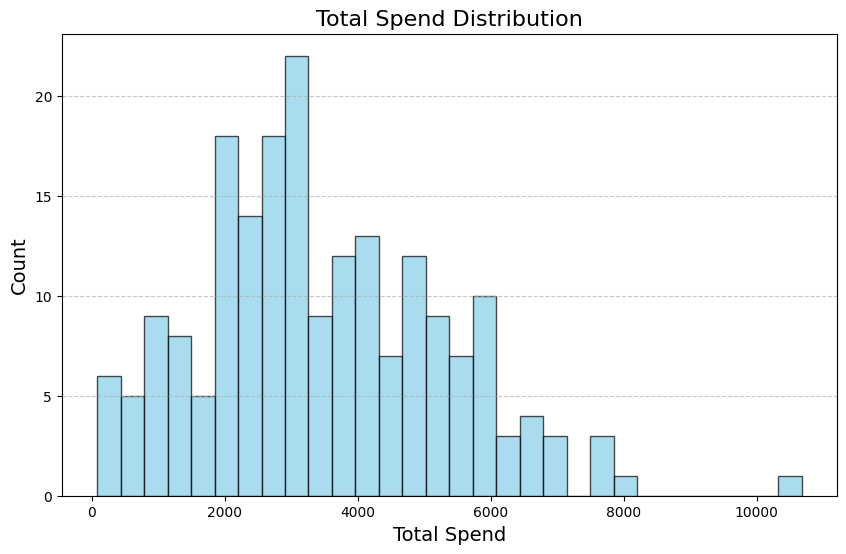

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(customer_features['totalSpend'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Total Spend Distribution', fontsize=16)
plt.xlabel('Total Spend', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

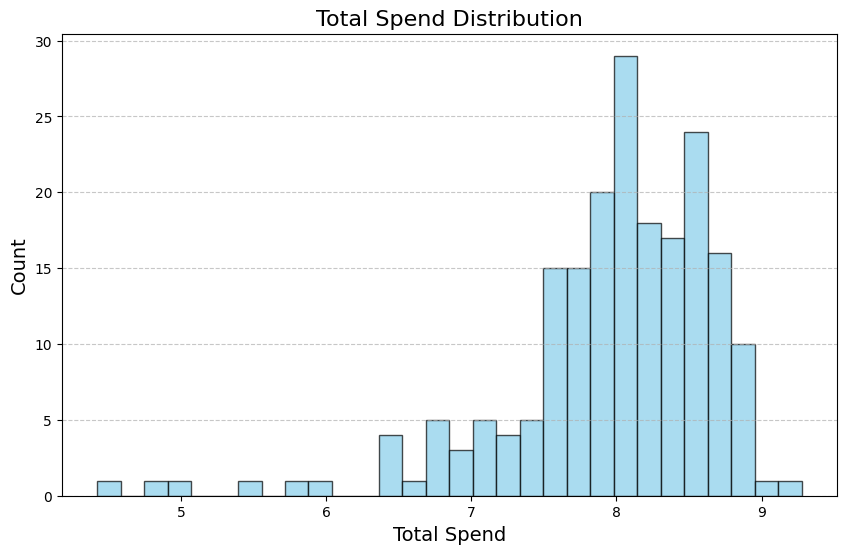

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(customer_features['Log_totalSpend'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Total Spend Distribution', fontsize=16)
plt.xlabel('Total Spend', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:

recommendations = generate_lookalike_recommendations(customer_features)

for customer, lookalikes in recommendations.items():
    print(f"Customer {customer} Lookalikes:")
    for lookalike, score in lookalikes:
        print(f"  - {lookalike} (Similarity: {score:.4f})")

Customer C0001 Lookalikes:
  - C0118 (Similarity: 0.9742)
  - C0184 (Similarity: 0.9654)
  - C0192 (Similarity: 0.9637)
Customer C0002 Lookalikes:
  - C0134 (Similarity: 0.9918)
  - C0159 (Similarity: 0.9809)
  - C0106 (Similarity: 0.9787)
Customer C0003 Lookalikes:
  - C0129 (Similarity: 0.9863)
  - C0031 (Similarity: 0.9802)
  - C0158 (Similarity: 0.9779)
Customer C0004 Lookalikes:
  - C0113 (Similarity: 0.9872)
  - C0104 (Similarity: 0.9745)
  - C0174 (Similarity: 0.9675)
Customer C0005 Lookalikes:
  - C0007 (Similarity: 0.9903)
  - C0140 (Similarity: 0.9628)
  - C0186 (Similarity: 0.9574)
Customer C0006 Lookalikes:
  - C0187 (Similarity: 0.9846)
  - C0085 (Similarity: 0.9618)
  - C0169 (Similarity: 0.9560)
Customer C0007 Lookalikes:
  - C0005 (Similarity: 0.9903)
  - C0140 (Similarity: 0.9706)
  - C0040 (Similarity: 0.9538)
Customer C0008 Lookalikes:
  - C0098 (Similarity: 0.9623)
  - C0194 (Similarity: 0.9553)
  - C0059 (Similarity: 0.9532)
Customer C0009 Lookalikes:
  - C0010 (Si

In [ ]:
customer_features

,CustomerID,LastTrans,TransactionCount,totalSpend,CustomerName,Region,SignupDate,Total_days,Books,Clothing,Electronics,Home Decor,Avg_spend,Trans_freq,Log_totalSpend,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,54,5,3354.52,Lawrence Carroll,South America,2022-07-10,901,1,0,3,1,670.904000,10.800000,8.118362,False,False,False,True
1,C0002,23,4,1862.74,Elizabeth Lutz,Asia,2022-02-13,1048,0,2,0,2,465.685000,5.750000,7.530341,True,False,False,False
2,C0003,124,4,2725.38,Michael Rivera,South America,2024-03-07,295,0,1,1,2,681.345000,31.000000,7.910730,False,False,False,True
3,C0004,3,8,5354.88,Kathleen Rodriguez,South America,2022-10-09,810,3,0,2,3,669.360000,0.375000,8.585950,False,False,False,True
4,C0005,52,3,2034.24,Laura Weber,Asia,2022-08-15,865,0,0,2,1,678.080000,17.333333,7.618369,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,11,4,4982.88,Laura Watts,Europe,2022-06-07,934,1,1,0,2,1245.720000,2.750000,8.513964,False,True,False,False
195,C0197,-1,3,1928.65,Christina Harvey,Europe,2023-03-21,647,0,0,2,1,642.883333,-0.333333,7.565094,False,True,False,False
196,C0198,83,2,931.83,Rebecca Ray,Europe,2022-02-27,1034,0,1,1,0,465.915000,41.500000,6.838223,False,True,False,False
197,C0199,61,4,1979.28,Andrea Jenkins,Europe,2022-12-03,755,0,0,2,2,494.820000,15.250000,7.590994,False,True,False,False
